Mounted at /content/drive


<ipython-input-18-038399417b94>:72: RuntimeWarning: Mean of empty slice
  forecast = np.nanmean(daily_percentages)


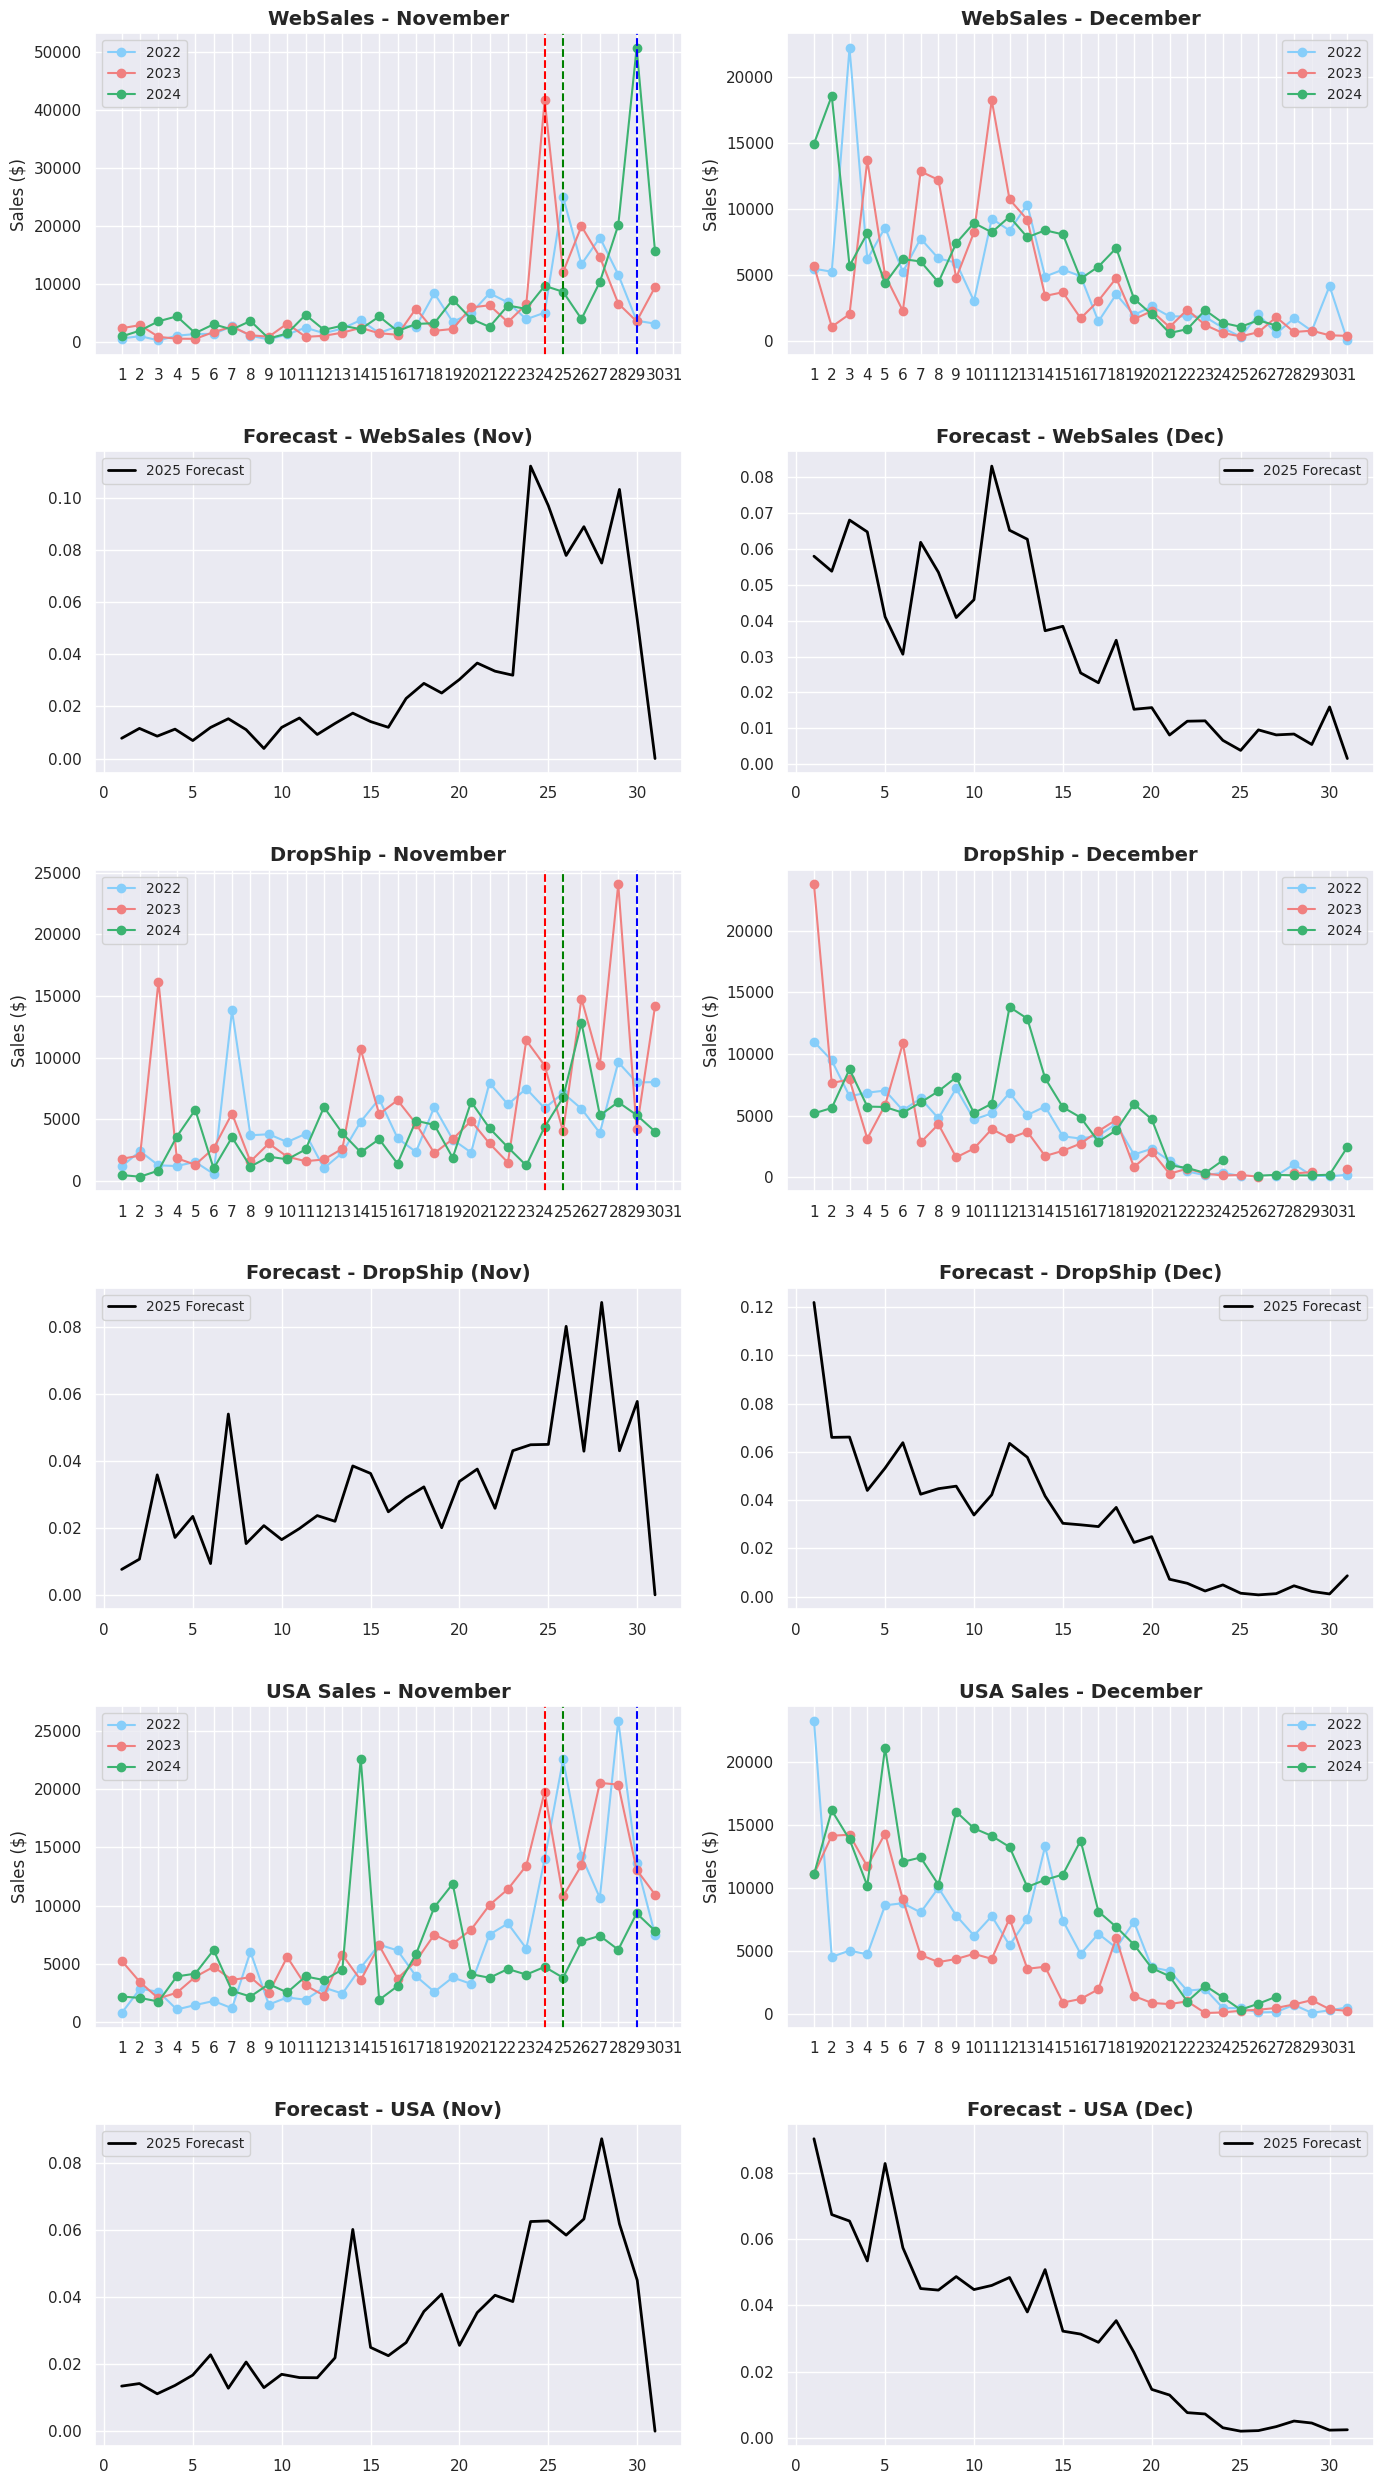

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from scipy.interpolate import make_interp_spline

# Set Seaborn style
sns.set_theme(style="darkgrid")

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Load dataset
file_path = "/content/drive/MyDrive/Graphing Data.csv"
df = pd.read_csv(file_path)

# Rename columns
df.rename(columns={'Dates': 'Date_WebSales', 'Dates.1': 'Date_DropShip', 'Dates.2': 'Date_USA',
                   'Websales': 'WebSales', 'Dropship': 'DropShip'}, inplace=True)

# Convert date columns
df['Date_WebSales'] = pd.to_datetime(df['Date_WebSales'], errors='coerce')
df['Date_DropShip'] = pd.to_datetime(df['Date_DropShip'], errors='coerce')
df['Date_USA'] = pd.to_datetime(df['Date_USA'], errors='coerce')

# Drop missing values
df = df.dropna(subset=['Date_WebSales', 'Date_DropShip', 'Date_USA', 'WebSales', 'DropShip', 'USA'])

# Melt DataFrame
df_melted = pd.melt(df, id_vars=['Date_WebSales', 'Date_DropShip', 'Date_USA'],
                     value_vars=['WebSales', 'DropShip', 'USA'],
                     var_name='Category', value_name='Sales')

# Assign correct date
df_melted['Date'] = df_melted.apply(lambda row: row['Date_WebSales'] if row['Category'] == 'WebSales'
                                    else (row['Date_DropShip'] if row['Category'] == 'DropShip'
                                          else row['Date_USA']), axis=1)

df_melted.drop(columns=['Date_WebSales', 'Date_DropShip', 'Date_USA'], inplace=True)

# Extract day & year
df_melted['Day'] = df_melted['Date'].dt.day
df_melted['Year'] = df_melted['Date'].dt.year

# Filter for November & December
november_data = df_melted[df_melted['Date'].dt.month == 11]
december_data = df_melted[df_melted['Date'].dt.month == 12]

# Group by day, year, category
november_grouped = november_data.groupby(['Day', 'Year', 'Category'])['Sales'].sum().unstack(level=[1, 2])
december_grouped = december_data.groupby(['Day', 'Year', 'Category'])['Sales'].sum().unstack(level=[1, 2])

# Forecast Calculation
def calculate_forecast(data, category):
    forecast_data = []
    for day in range(1, 32):
        daily_percentages = []
        for year in [2022, 2023, 2024]:
            try:
                daily_sales = data.loc[day, (year, category)]
                monthly_total = data.loc[:, (year, category)].sum()

                if monthly_total > 0:
                    daily_percentages.append(daily_sales / monthly_total)
                else:
                    daily_percentages.append(0)
            except KeyError:
                daily_percentages.append(np.nan)

        forecast = np.nanmean(daily_percentages)

        if np.isnan(forecast) or np.isinf(forecast):
            forecast = 0

        forecast_data.append(forecast)
    return forecast_data

# Create 6x2 subplot grid
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(14, 25), sharex=False, sharey=False)

# Function to plot sales trends
def plot_sales_trend(ax, data, title, category, colors, add_dashed_lines=False):
    if category in data.columns.levels[1]:
        for year, color in zip([2022, 2023, 2024], colors):
            if (year, category) in data.columns:
                ax.plot(data.index, data[(year, category)], label=f'{year}', color=color, marker='o', linestyle='-')

        if add_dashed_lines:
            black_friday_dates = {2022: (25, 'green'), 2023: (24, 'red'), 2024: (29, 'blue')}
            for year, (day, line_color) in black_friday_dates.items():
                ax.axvline(x=day, color=line_color, linestyle='dashed', linewidth=1.5)

        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.set_ylabel('Sales ($)', fontsize=12)
        ax.legend(fontsize=10)
        ax.set_xticks(range(1, 32))
        ax.tick_params(axis='x')

# Define colors
colors = ['lightskyblue', 'lightcoral', 'mediumseagreen']

# Order of plots: [WebSales -> WebSales Forecast], [DropShip -> DropShip Forecast], [USA -> USA Forecast]

# WebSales
plot_sales_trend(axes[0, 0], november_grouped, 'WebSales - November', 'WebSales', colors, add_dashed_lines=True)
plot_sales_trend(axes[0, 1], december_grouped, 'WebSales - December', 'WebSales', colors, add_dashed_lines=False)

# DropShip
plot_sales_trend(axes[2, 0], november_grouped, 'DropShip - November', 'DropShip', colors, add_dashed_lines=True)
plot_sales_trend(axes[2, 1], december_grouped, 'DropShip - December', 'DropShip', colors, add_dashed_lines=False)

# USA Sales
plot_sales_trend(axes[4, 0], november_grouped, 'USA Sales - November', 'USA', colors, add_dashed_lines=True)
plot_sales_trend(axes[4, 1], december_grouped, 'USA Sales - December', 'USA', colors, add_dashed_lines=False)

# Add Forecast Graphs Right Below Each Category
for i, category in enumerate(['WebSales', 'DropShip', 'USA']):
    nov_forecast = calculate_forecast(november_grouped, category)
    dec_forecast = calculate_forecast(december_grouped, category)

    # Create smooth curve
    days = np.array(range(1, 32))
    nov_forecast_smooth = make_interp_spline(days, nov_forecast, k=3)(days)
    dec_forecast_smooth = make_interp_spline(days, dec_forecast, k=3)(days)

    # Forecast plots (Directly below the corresponding sales plot)
    axes[(i * 2) + 1, 0].plot(days, nov_forecast_smooth, label='2025 Forecast', color='black', linewidth=2)
    axes[(i * 2) + 1, 1].plot(days, dec_forecast_smooth, label='2025 Forecast', color='black', linewidth=2)

    axes[(i * 2) + 1, 0].set_title(f'Forecast - {category} (Nov)', fontsize=14, fontweight='bold')
    axes[(i * 2) + 1, 1].set_title(f'Forecast - {category} (Dec)', fontsize=14, fontweight='bold')

    axes[(i * 2) + 1, 0].legend(fontsize=10)
    axes[(i * 2) + 1, 1].legend(fontsize=10)

# Adjust layout
plt.tight_layout(h_pad=2.5)
plt.subplots_adjust(hspace=0.3)
plt.show()

In [2]:
!apt-get install git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.12).
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.


In [4]:
!git config --global user.name "KahanC"
!git config --global user.email "kjchoksi@uwaterloo.ca"

In [5]:
!git config --list

filter.lfs.smudge=git-lfs smudge -- %f
filter.lfs.process=git-lfs filter-process
filter.lfs.required=true
filter.lfs.clean=git-lfs clean -- %f
user.name=KahanC
user.email=kjchoksi@uwaterloo.ca


In [6]:
!git clone https://github.com/KahanC/Sales-Forecasting.git

Cloning into 'Sales-Forecasting'...


In [7]:
%cd Sales-Forecasting

/content/Sales-Forecasting


In [8]:
!pwd

/content/Sales-Forecasting


In [22]:
!ls /content/Notebooks/ /content/drive/MyDrive/Colab Notebooks/Sales_Forecast.ipynb

ls: cannot access '/content/Notebooks/': No such file or directory
